In [1]:
!pip install torch torchvision torchaudio --quiet

import os
import random
from collections import defaultdict

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import datasets, transforms, models

from google.colab import drive

from collections import Counter
import pandas as pd
import os


In [2]:

drive.mount('/content/drive')

DATA_ROOT = "/content/drive/MyDrive/DL_Project_Dataset"

SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Mounted at /content/drive
Using device: cuda


In [3]:
CLASS_NAMES = [
    "Ford_F-150_(thirteenth_generation)",
    "Ford_Mustang_VI",
    "Renault_Kangoo_I",
    "Renault_Twizy_Z.E.",
    "Toyota_Land_Cruiser_(J40)",
    "Toyota_Supra_(A80)",
    "Volkswagen_Passat_B6",
    "Volkswagen_Type_1",
]

print("Expected folders:")
for name in CLASS_NAMES:
    print(" -", name)


Expected folders:
 - Ford_F-150_(thirteenth_generation)
 - Ford_Mustang_VI
 - Renault_Kangoo_I
 - Renault_Twizy_Z.E.
 - Toyota_Land_Cruiser_(J40)
 - Toyota_Supra_(A80)
 - Volkswagen_Passat_B6
 - Volkswagen_Type_1


In [4]:
tmp_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

full_dataset = datasets.ImageFolder(root=DATA_ROOT, transform=tmp_transform)

print("ImageFolder classes:", full_dataset.classes)

for idx, cls_name in enumerate(full_dataset.classes):
    print(idx, "->", cls_name)




total_images = len(full_dataset.samples)
num_classes  = len(full_dataset.classes)

print(f"\n\nTotal images: {total_images}")
print(f"Num classes : {num_classes}")

#per-class counts
class_counts = Counter([y for _, y in full_dataset.samples])

df_class = pd.DataFrame([
    {"class_idx": i, "class_name": name, "n_images": class_counts.get(i, 0)}
    for i, name in enumerate(full_dataset.classes)
]).sort_values("n_images", ascending=False).reset_index(drop=True)

df_class["percentage"] = (df_class["n_images"] / total_images * 100).round(2)

display(df_class)

#file format
ext_counts = Counter([os.path.splitext(p)[1].lower() for p, _ in full_dataset.samples])

df_ext = pd.DataFrame([
    {"format": ext if ext else "(no_ext)", "n_images": n, "percentage": round(n / total_images * 100, 2)}
    for ext, n in ext_counts.items()
]).sort_values("n_images", ascending=False).reset_index(drop=True)

display(df_ext)


ImageFolder classes: ['Ford_F-150_(thirteenth_generation)', 'Ford_Mustang_VI', 'Renault_Kangoo_I', 'Renault_Twizy_Z.E.', 'Toyota_Land_Cruiser_(J40)', 'Toyota_Supra_(A80)', 'Volkswagen_Passat_B6', 'Volkswagen_Type_1']
0 -> Ford_F-150_(thirteenth_generation)
1 -> Ford_Mustang_VI
2 -> Renault_Kangoo_I
3 -> Renault_Twizy_Z.E.
4 -> Toyota_Land_Cruiser_(J40)
5 -> Toyota_Supra_(A80)
6 -> Volkswagen_Passat_B6
7 -> Volkswagen_Type_1


Total images: 80
Num classes : 8


,class_idx,class_name,n_images,percentage
0,0,Ford_F-150_(thirteenth_generation),10,12.5
1,1,Ford_Mustang_VI,10,12.5
2,2,Renault_Kangoo_I,10,12.5
3,3,Renault_Twizy_Z.E.,10,12.5
4,4,Toyota_Land_Cruiser_(J40),10,12.5
5,5,Toyota_Supra_(A80),10,12.5
6,6,Volkswagen_Passat_B6,10,12.5
7,7,Volkswagen_Type_1,10,12.5


,format,n_images,percentage
0,.jpg,80,100.0


In [5]:
brand_id_for_class = {
    # class_index : brand_index
    0: 0,  # Ford_F-150_(thirteenth_generation)   -> Ford
    1: 0,  # Ford_Mustang_VI                      -> Ford
    2: 1,  # Renault_Kangoo_I                     -> Renault
    3: 1,  # Renault_Twizy_Z.E.                   -> Renault
    4: 2,  # Toyota_Land_Cruiser_(J40)            -> Toyota
    5: 2,  # Toyota_Supra_(A80)                   -> Toyota
    6: 3,  # Volkswagen_Passat_B6                 -> VW
    7: 3,  # Volkswagen_Type_1                    -> VW
}

brand_names = ["Ford", "Renault", "Toyota", "Volkswagen"]

classes_for_brand = {
    0: [0, 1],  # Ford
    1: [2, 3],  # Renault
    2: [4, 5],  # Toyota
    3: [6, 7],  # VW
}

print("Brand mapping:")
for cls_idx, br_idx in brand_id_for_class.items():
    print(f"Class {cls_idx} ({full_dataset.classes[cls_idx]}) -> Brand {br_idx} ({brand_names[br_idx]})")


class BrandDataset(Dataset):
    def __init__(self, base_dataset, brand_id_for_class):
        self.base_dataset = base_dataset
        self.brand_id_for_class = brand_id_for_class

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        img, original_class = self.base_dataset[idx]
        brand_label = self.brand_id_for_class[original_class]
        return img, brand_label


class SubsetForBrandModels(Dataset):
    def __init__(self, base_dataset, allowed_class_indices):
        self.base_dataset = base_dataset
        self.allowed = allowed_class_indices

        self.indices = []
        self.new_labels = []

        class_to_new = {cls_idx: i for i, cls_idx in enumerate(self.allowed)}

        for i in range(len(base_dataset)):
            _, original_class = base_dataset[i]
            if original_class in self.allowed:
                self.indices.append(i)
                self.new_labels.append(class_to_new[original_class])

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        base_idx = self.indices[idx]
        img, _ = self.base_dataset[base_idx]
        label = self.new_labels[idx]
        return img, label


Brand mapping:
Class 0 (Ford_F-150_(thirteenth_generation)) -> Brand 0 (Ford)
Class 1 (Ford_Mustang_VI) -> Brand 0 (Ford)
Class 2 (Renault_Kangoo_I) -> Brand 1 (Renault)
Class 3 (Renault_Twizy_Z.E.) -> Brand 1 (Renault)
Class 4 (Toyota_Land_Cruiser_(J40)) -> Brand 2 (Toyota)
Class 5 (Toyota_Supra_(A80)) -> Brand 2 (Toyota)
Class 6 (Volkswagen_Passat_B6) -> Brand 3 (Volkswagen)
Class 7 (Volkswagen_Type_1) -> Brand 3 (Volkswagen)


In [6]:
from sklearn.model_selection import train_test_split

IMG_SIZE = 224

train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])


base_dataset_train = datasets.ImageFolder(root=DATA_ROOT, transform=train_transform)
base_dataset_val   = datasets.ImageFolder(root=DATA_ROOT, transform=val_transform)


indices = list(range(len(base_dataset_train)))
train_idx, val_idx = train_test_split(
    indices,
    test_size=0.2,
    random_state=SEED,
    shuffle=True,
    stratify=[full_dataset[i][1] for i in indices]
)

print("Train size:", len(train_idx), "Val size:", len(val_idx))

Train size: 64 Val size: 16


In [7]:
all_labels = [full_dataset[i][1] for i in indices]

train_labels = [all_labels[i] for i in train_idx]
val_labels   = [all_labels[i] for i in val_idx]

train_counts = Counter(train_labels)
val_counts   = Counter(val_labels)

df_split = pd.DataFrame([
    {
        "class_idx": c,
        "class_name": full_dataset.classes[c],
        "train_n": train_counts.get(c, 0),
        "val_n": val_counts.get(c, 0),
    }
    for c in range(len(full_dataset.classes))
])

df_split["train_percentage"] = (df_split["train_n"] / len(train_idx) * 100).round(2)
df_split["val_percentage"]   = (df_split["val_n"]   / len(val_idx)   * 100).round(2)

display(df_split.sort_values("train_n", ascending=False).reset_index(drop=True))


train_brand = [brand_id_for_class[c] for c in train_labels]
val_brand   = [brand_id_for_class[c] for c in val_labels]

train_brand_counts = Counter(train_brand)
val_brand_counts   = Counter(val_brand)

df_brand = pd.DataFrame([
    {
        "brand_idx": b,
        "brand_name": brand_names[b],
        "train_n": train_brand_counts.get(b, 0),
        "val_n": val_brand_counts.get(b, 0),
    }
    for b in range(len(brand_names))
])

df_brand["train_percentage"] = (df_brand["train_n"] / len(train_idx) * 100).round(2)
df_brand["val_percentage"]   = (df_brand["val_n"]   / len(val_idx)   * 100).round(2)

display(df_brand.sort_values("train_n", ascending=False).reset_index(drop=True))

,class_idx,class_name,train_n,val_n,train_percentage,val_percentage
0,0,Ford_F-150_(thirteenth_generation),8,2,12.5,12.5
1,1,Ford_Mustang_VI,8,2,12.5,12.5
2,2,Renault_Kangoo_I,8,2,12.5,12.5
3,3,Renault_Twizy_Z.E.,8,2,12.5,12.5
4,4,Toyota_Land_Cruiser_(J40),8,2,12.5,12.5
5,5,Toyota_Supra_(A80),8,2,12.5,12.5
6,6,Volkswagen_Passat_B6,8,2,12.5,12.5
7,7,Volkswagen_Type_1,8,2,12.5,12.5


,brand_idx,brand_name,train_n,val_n,train_percentage,val_percentage
0,0,Ford,16,4,25.0,25.0
1,1,Renault,16,4,25.0,25.0
2,2,Toyota,16,4,25.0,25.0
3,3,Volkswagen,16,4,25.0,25.0


In [8]:
BATCH_SIZE = 32

brand_dataset_train_full = BrandDataset(base_dataset_train, brand_id_for_class)
brand_dataset_val_full   = BrandDataset(base_dataset_val,   brand_id_for_class)

brand_train_ds = Subset(brand_dataset_train_full, train_idx)
brand_val_ds   = Subset(brand_dataset_val_full,   val_idx)

brand_train_loader = DataLoader(brand_train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
brand_val_loader   = DataLoader(brand_val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print("Brand train batches:", len(brand_train_loader))
print("Brand val batches:", len(brand_val_loader))


Brand train batches: 2
Brand val batches: 1


In [9]:
import torch
import torch.nn as nn

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()

        self.conv1 = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False
        )
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(
            out_channels,
            out_channels,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out = out + identity
        out = self.relu(out)
        return out


class CustomResNet18(nn.Module):

    def __init__(self, num_classes=4):
        super(CustomResNet18, self).__init__()

        self.in_channels = 64

        self.conv1 = nn.Conv2d(
            3, 64,
            kernel_size=7,
            stride=2,
            padding=3,
            bias=False
        )
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(BasicBlock, 64,  2, stride=1)
        self.layer2 = self._make_layer(BasicBlock, 128, 2, stride=2)
        self.layer3 = self._make_layer(BasicBlock, 256, 2, stride=2)
        self.layer4 = self._make_layer(BasicBlock, 512, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        self.dropout = nn.Dropout(p=0.3)

        self.fc = nn.Linear(512 * BasicBlock.expansion, num_classes)

        self._init_weights()

    def _make_layer(self, block, out_channels, blocks, stride=1):

        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    out_channels * block.expansion,
                    kernel_size=1,
                    stride=stride,
                    bias=False
                ),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion

        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def _init_weights(self):

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1.)
                nn.init.constant_(m.bias, 0.)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0.)

    def forward(self, x):

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)   #64
        x = self.layer2(x)   #128
        x = self.layer3(x)   #256
        x = self.layer4(x)   #512

        x = self.avgpool(x)
        x = torch.flatten(x, 1)  #(B, 512)

        x = self.dropout(x)
        x = self.fc(x)
        return x


In [10]:
import copy
import math

def create_resnet(num_classes):

    model = CustomResNet18(num_classes=num_classes)
    return model.to(device)


def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    running_correct = 0
    total = 0

    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        preds = outputs.argmax(dim=1)
        running_loss += loss.item() * images.size(0)
        running_correct += (preds == labels).sum().item()
        total += images.size(0)

    epoch_loss = running_loss / total
    epoch_acc  = running_correct / total
    return epoch_loss, epoch_acc


def evaluate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    running_correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            preds = outputs.argmax(dim=1)
            running_loss += loss.item() * images.size(0)
            running_correct += (preds == labels).sum().item()
            total += images.size(0)

    epoch_loss = running_loss / total
    epoch_acc  = running_correct / total
    return epoch_loss, epoch_acc


def train_model(model, train_loader, val_loader, num_epochs=20, lr=1e-3):

    history = {
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": []
    }
    best_state = None
    best_val_acc = -1.0

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    criterion = nn.CrossEntropyLoss()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_acc = 0.0

    for epoch in range(num_epochs):
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer)
        val_loss, val_acc     = evaluate(model, val_loader, criterion)
        scheduler.step()

        print(f"Epoch {epoch+1:02d}/{num_epochs:02d} "
              f"- train loss: {train_loss:.4f}, acc: {train_acc:.4f} "
              f"- val loss: {val_loss:.4f}, acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)


    print("Best val acc:", best_val_acc)
    model.load_state_dict(best_model_wts)
    return model, history


In [11]:
#confusion matrix collection

import numpy as np
import matplotlib.pyplot as plt

@torch.no_grad()
def collect_preds(model, loader):
    model.eval()
    all_y, all_p = [], []
    for x, y in loader:
        x = x.to(device)
        logits = model(x)
        p = logits.argmax(dim=1).cpu().numpy()
        all_p.extend(p.tolist())
        all_y.extend(y.numpy().tolist())
    return np.array(all_y), np.array(all_p)

In [12]:
#loss-acc graphs

import matplotlib.pyplot as plt

def plot_history(history, title="Training Curves"):
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure()
    plt.plot(epochs, history["train_loss"], label="train_loss")
    plt.plot(epochs, history["val_loss"], label="val_loss")
    plt.title(title + " (Loss)")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(epochs, history["train_acc"], label="train_acc")
    plt.plot(epochs, history["val_acc"], label="val_acc")
    plt.title(title + " (Accuracy)")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

Linear(in_features=512, out_features=4, bias=True)
Epoch 01/30 - train loss: 1.3502, acc: 0.3125 - val loss: 3.3951, acc: 0.2500
Epoch 02/30 - train loss: 1.3810, acc: 0.3750 - val loss: 1.6285, acc: 0.3125
Epoch 03/30 - train loss: 1.2220, acc: 0.5156 - val loss: 1.3159, acc: 0.3750
Epoch 04/30 - train loss: 1.1552, acc: 0.4531 - val loss: 1.4841, acc: 0.3750
Epoch 05/30 - train loss: 1.0832, acc: 0.5312 - val loss: 1.7259, acc: 0.3125
Epoch 06/30 - train loss: 1.0143, acc: 0.5312 - val loss: 1.8661, acc: 0.4375
Epoch 07/30 - train loss: 0.9711, acc: 0.6094 - val loss: 1.8119, acc: 0.3125
Epoch 08/30 - train loss: 0.8601, acc: 0.6406 - val loss: 1.6791, acc: 0.3125
Epoch 09/30 - train loss: 0.8353, acc: 0.6719 - val loss: 1.6735, acc: 0.3125
Epoch 10/30 - train loss: 0.7240, acc: 0.6875 - val loss: 2.3185, acc: 0.3125
Epoch 11/30 - train loss: 0.7590, acc: 0.7344 - val loss: 2.7112, acc: 0.3750
Epoch 12/30 - train loss: 0.6488, acc: 0.7656 - val loss: 2.4319, acc: 0.5000
Epoch 13/30 -

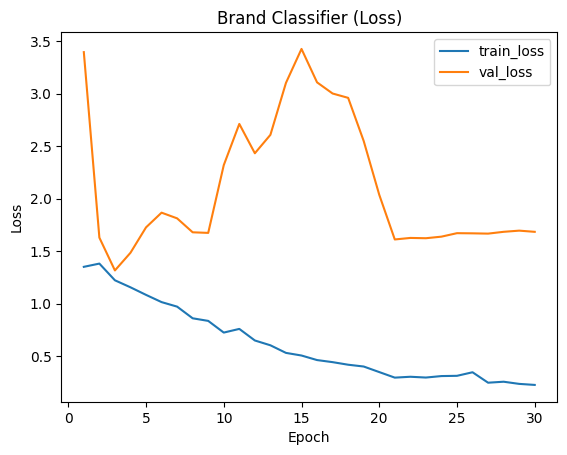

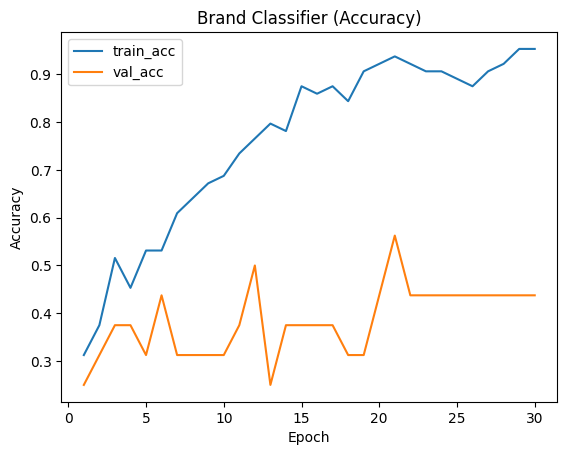

In [13]:
NUM_BRANDS = 4

brand_model = create_resnet(num_classes=NUM_BRANDS)
print(brand_model.fc)

brand_model, history = train_model(
    brand_model,
    brand_train_loader,
    brand_val_loader,
    num_epochs=30,
    lr=3e-4
)

os.makedirs("/content/models", exist_ok=True)
torch.save(brand_model.state_dict(), "/content/models/brand_classifier_resnet18.pth")
print("Brand model saved.")
plot_history(history, title="Brand Classifier")


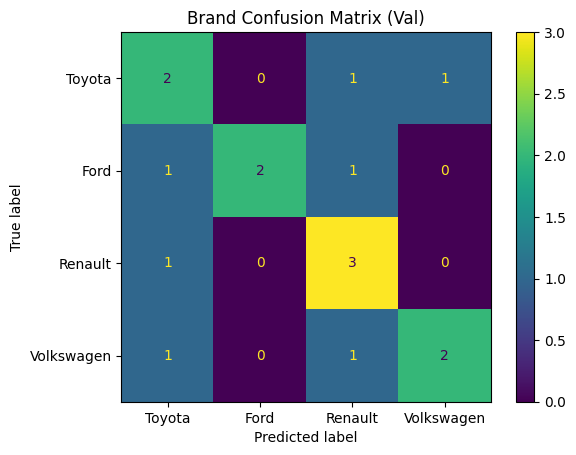

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

BRANDS = ["Toyota", "Ford", "Renault", "Volkswagen"]

y_true, y_pred = collect_preds(brand_model, brand_val_loader)
cm = confusion_matrix(y_true, y_pred, labels=[0,1,2,3])
disp = ConfusionMatrixDisplay(cm, display_labels=BRANDS)
disp.plot(values_format="d")
plt.title("Brand Confusion Matrix (Val)")
plt.show()

In [15]:
brand_model_dataloaders = {}

for brand_idx, class_indices in classes_for_brand.items():

    ds_train_brand = SubsetForBrandModels(base_dataset_train, class_indices)
    ds_val_brand   = SubsetForBrandModels(base_dataset_val,   class_indices)

    train_loader = DataLoader(ds_train_brand, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    val_loader   = DataLoader(ds_val_brand,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

    brand_model_dataloaders[brand_idx] = (train_loader, val_loader)
    print(f"Brand {brand_idx} ({brand_names[brand_idx]}): "
          f"train size = {len(ds_train_brand)}, val size = {len(ds_val_brand)}")


Brand 0 (Ford): train size = 20, val size = 20
Brand 1 (Renault): train size = 20, val size = 20
Brand 2 (Toyota): train size = 20, val size = 20
Brand 3 (Volkswagen): train size = 20, val size = 20



Training model for brand 0 (Ford)
Epoch 01/01 - train loss: 0.6919, acc: 0.5000 - val loss: 1.8326, acc: 0.5000
Best val acc: 0.5
Saved: /content/models/model_classifier_brand0_Ford.pth


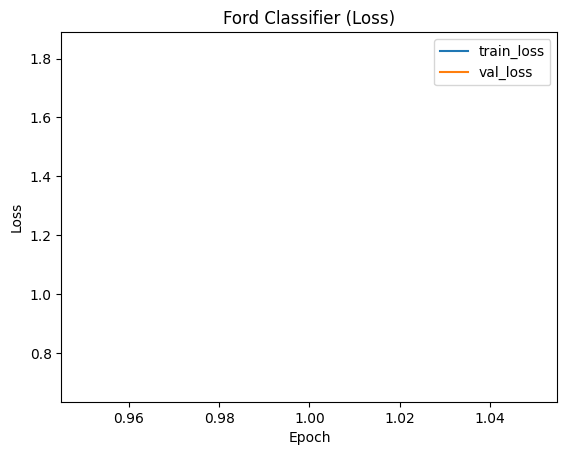

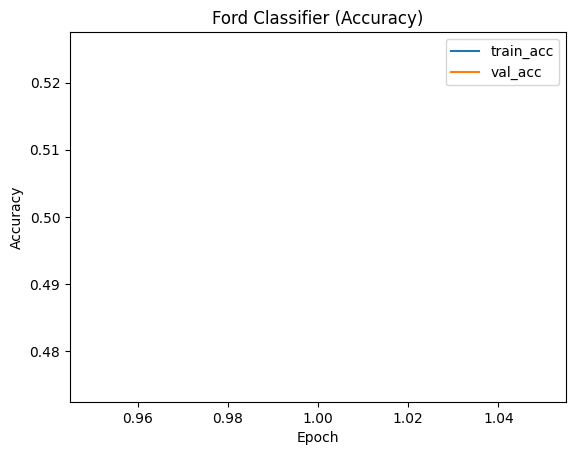

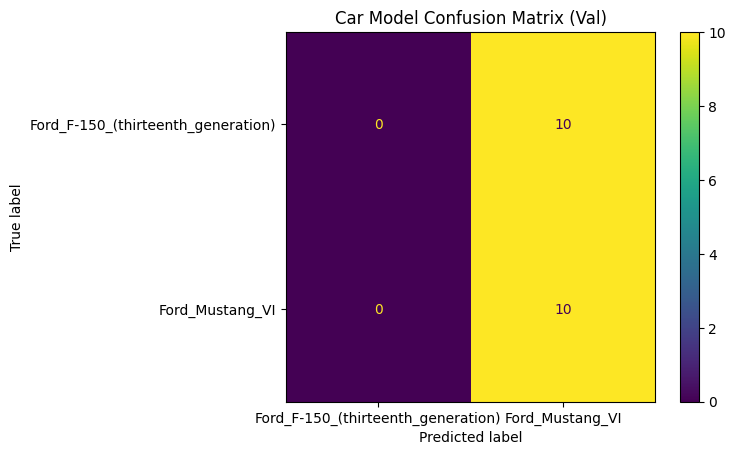


Training model for brand 1 (Renault)
Epoch 01/01 - train loss: 0.6882, acc: 0.4500 - val loss: 0.6992, acc: 0.5000
Best val acc: 0.5
Saved: /content/models/model_classifier_brand1_Renault.pth


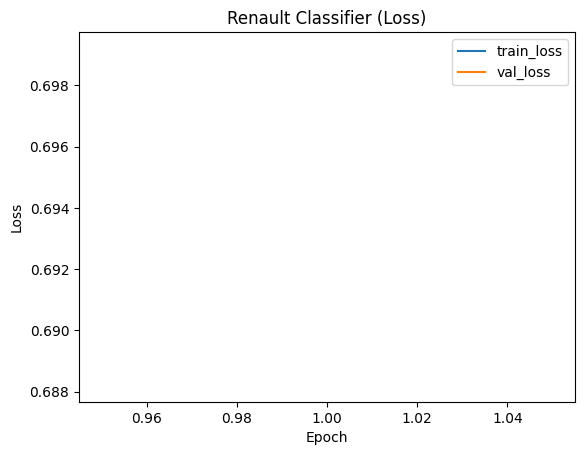

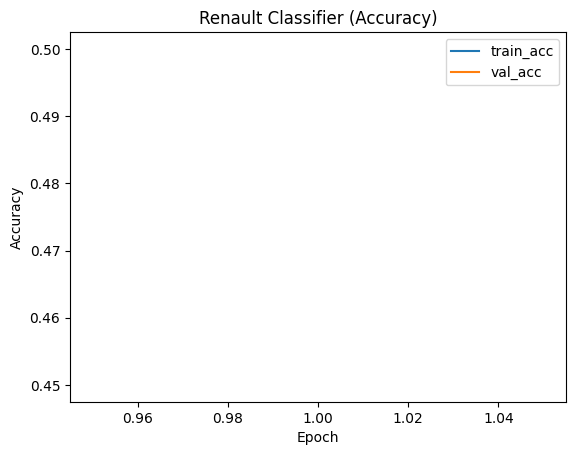

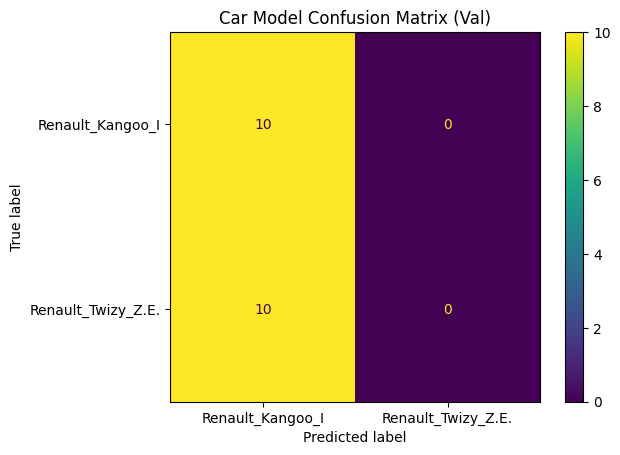


Training model for brand 2 (Toyota)


KeyboardInterrupt: 

In [26]:
brand_specific_models = {}

for brand_idx in range(NUM_BRANDS):
    train_loader, val_loader = brand_model_dataloaders[brand_idx]

    print("\n==============================")
    print(f"Training model for brand {brand_idx} ({brand_names[brand_idx]})")
    print("==============================")

    model_m = create_resnet(num_classes=2)

    model_m, history = train_model(
        model_m,
        train_loader,
        val_loader,
        num_epochs=20,
        lr=3e-4
    )

    model_path = f"/content/models/model_classifier_brand{brand_idx}_{brand_names[brand_idx]}.pth"
    torch.save(model_m.state_dict(), model_path)
    print("Saved:", model_path)

    brand_specific_models[brand_idx] = model_m



    plot_history(history, title=brand_names[brand_idx] + " Classifier")

    class_indices = classes_for_brand[brand_idx]
    first, second = full_dataset.classes[class_indices[0]], full_dataset.classes[class_indices[1]]

    BRANDS = [first, second]

    y_true, y_pred = collect_preds(model_m, val_loader)
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    disp = ConfusionMatrixDisplay(cm, display_labels=BRANDS)
    disp.plot(values_format="d")
    plt.title("Car Model Confusion Matrix (Val)")
    plt.show()


In [ ]:
from PIL import Image

def load_single_image(img_path):
    img = Image.open(img_path).convert("RGB")
    img_t = val_transform(img).unsqueeze(0).to(device)
    return img_t

def predict_brand_and_model(img_path, brand_model, brand_specific_models):
    img_t = load_single_image(img_path)

    brand_model.eval()
    with torch.no_grad():
        out_brand = brand_model(img_t)
        brand_pred = out_brand.argmax(dim=1).item()

    model_clf = brand_specific_models[brand_pred]
    model_clf.eval()
    with torch.no_grad():
        out_model = model_clf(img_t)
        model_pred = out_model.argmax(dim=1).item()

    class_indices = classes_for_brand[brand_pred]
    model_class_idx = class_indices[model_pred]
    model_class_name = full_dataset.classes[model_class_idx]

    return brand_names[brand_pred], model_class_name

In [ ]:
test_img_path = "/content/Test/Ford F-150.jpg"
b, m = predict_brand_and_model(test_img_path, brand_model, brand_specific_models)
print("Predicted brand:", b, " model:", m)

test_img_path = "/content/Test/Ford Mustang.jpg"
b, m = predict_brand_and_model(test_img_path, brand_model, brand_specific_models)
print("Predicted brand:", b, " model:", m)

test_img_path = "/content/Test/Renault Kangoo.jpg"
b, m = predict_brand_and_model(test_img_path, brand_model, brand_specific_models)
print("Predicted brand:", b, " model:", m)

test_img_path = "/content/Test/Renault Twizy.jpg"
b, m = predict_brand_and_model(test_img_path, brand_model, brand_specific_models)
print("Predicted brand:", b, " model:", m)

test_img_path = "/content/Test/Toyota Land Cruiser.jpeg"
b, m = predict_brand_and_model(test_img_path, brand_model, brand_specific_models)
print("Predicted brand:", b, " model:", m)

test_img_path = "/content/Test/Toyota_Supra.jpg"
b, m = predict_brand_and_model(test_img_path, brand_model, brand_specific_models)
print("Predicted brand:", b, " model:", m)

test_img_path = "/content/Test/Volkswagen Passat.jpg"
b, m = predict_brand_and_model(test_img_path, brand_model, brand_specific_models)
print("Predicted brand:", b, " model:", m)

test_img_path = "/content/Test/Volkswagen Type I.jpg"
b, m = predict_brand_and_model(test_img_path, brand_model, brand_specific_models)
print("Predicted brand:", b, " model:", m)

Predicted brand: Ford  model: Ford_F-150_(thirteenth_generation)
Predicted brand: Volkswagen  model: Volkswagen_Type_1
Predicted brand: Renault  model: Renault_Kangoo_I
Predicted brand: Renault  model: Renault_Twizy_Z.E
Predicted brand: Toyota  model: Toyota_Land_Cruiser_(J40)
Predicted brand: Toyota  model: Toyota_Supra_(A80)
Predicted brand: Volkswagen  model: Volkswagen_Passat_B6
Predicted brand: Volkswagen  model: Volkswagen_Type_1
